In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

In [30]:
ticker = "AAPL"
period = "2y"

In [31]:
stock = yf.Ticker(ticker)
df = stock.history(period=period)

In [32]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0


In [33]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-10-02 00:00:00-04:00 to 2025-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          500 non-null    float64
 1   High          500 non-null    float64
 2   Low           500 non-null    float64
 3   Close         500 non-null    float64
 4   Volume        500 non-null    int64  
 5   Dividends     500 non-null    float64
 6   Stock Splits  500 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.2 KB


None

In [34]:
display(df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.0
mean,207.738319,209.926378,205.812891,208.011329,5.666703e+07,0.004000,0.0
std,23.979089,24.177124,23.699435,24.019448,2.683536e+07,0.031413,0.0
min,164.171070,165.213575,162.910124,163.823563,2.323470e+07,0.000000,0.0
25%,188.134679,189.477336,186.529185,188.053135,4.235552e+07,0.000000,0.0
50%,210.304070,212.839909,208.062397,210.797462,5.021880e+07,0.000000,0.0
75%,227.290368,229.308174,224.948898,227.185852,6.178472e+07,0.000000,0.0
max,257.276679,259.179926,256.718662,258.103729,3.186799e+08,0.260000,0.0


In [35]:
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [36]:
missing_values = df.isnull().sum()
print("Missing values per column:")
display(missing_values)

Missing values per column:


,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [37]:
print(f"Data starts from: {df.index.min()}")
print(f"Data ends on: {df.index.max()}")

Data starts from: 2023-10-02 00:00:00-04:00
Data ends on: 2025-09-29 00:00:00-04:00


In [38]:
price_min = df['Close'].min()
price_max = df['Close'].max()
price_range = price_max - price_min
price_mean = df['Close'].mean()
price_median = df['Close'].median()

volume_min = df['Volume'].min()
volume_max = df['Volume'].max()
volume_mean = df['Volume'].mean()
volume_median = df['Volume'].median()

print("Price Analysis:")
display(f"Minimum Close Price: ${price_min:.2f}")
display(f"Maximum Close Price: ${price_max:.2f}")
display(f"Price Range: ${price_range:.2f}")
display(f"Average Close Price: ${price_mean:.2f}")
display(f"Median Close Price: ${price_median:.2f}")

print("\nVolume Analysis:")
display(f"Minimum Volume: {volume_min:,}")
display(f"Maximum Volume: {volume_max:,}")
display(f"Average Volume: {volume_mean:,.0f}")
display(f"Median Volume: {volume_median:,.0f}")

Price Analysis:


'Minimum Close Price: $163.82'

'Maximum Close Price: $258.10'

'Price Range: $94.28'

'Average Close Price: $208.01'

'Median Close Price: $210.80'


Volume Analysis:


'Minimum Volume: 23,234,700'

'Maximum Volume: 318,679,900'

'Average Volume: 56,667,025'

'Median Volume: 50,218,800'

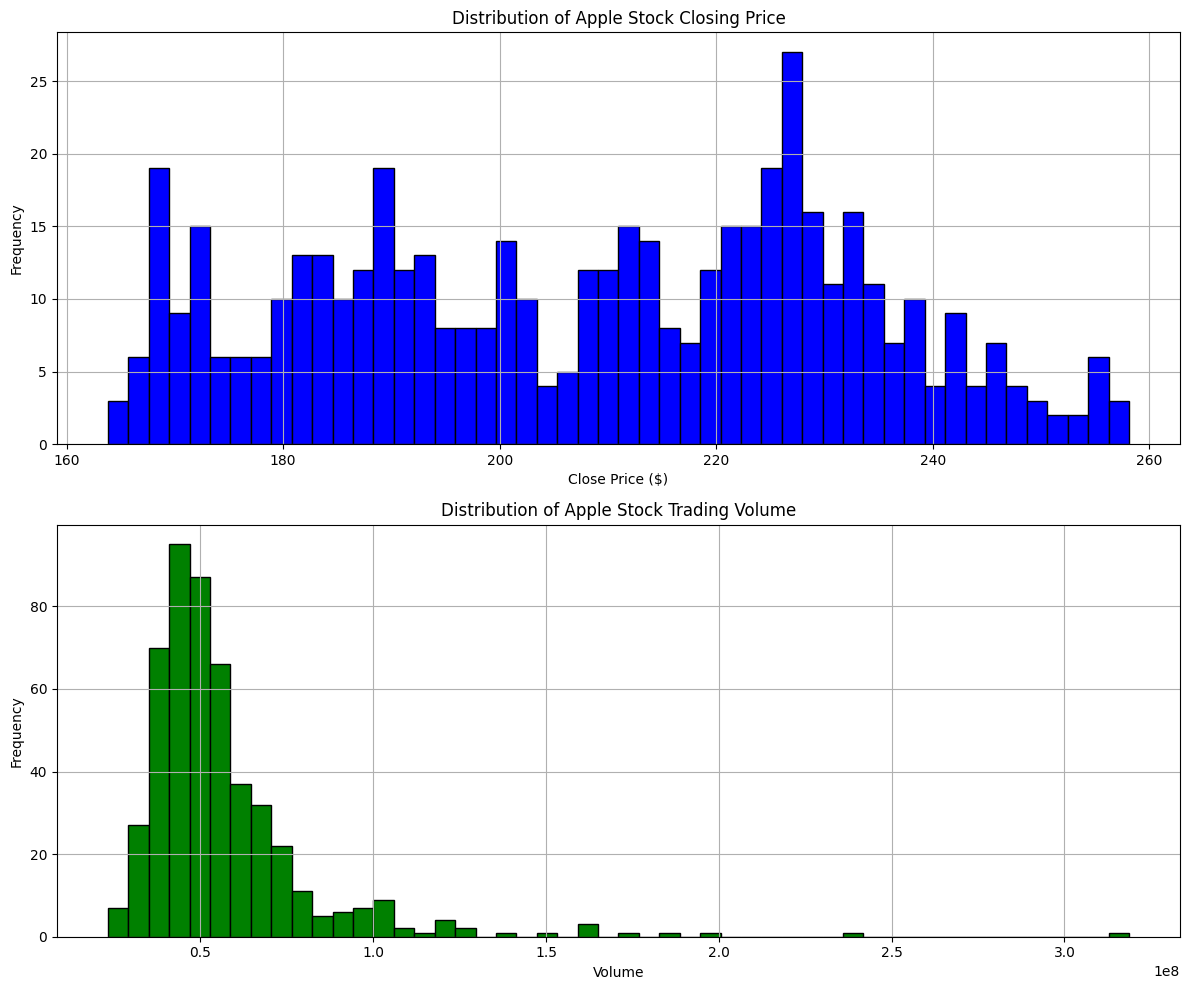

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

axes[0].hist(df['Close'], bins=50, color='blue', edgecolor='black')
axes[0].set_title('Distribution of Apple Stock Closing Price')
axes[0].set_xlabel('Close Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

axes[1].hist(df['Volume'], bins=50, color='green', edgecolor='black')
axes[1].set_title('Distribution of Apple Stock Trading Volume')
axes[1].set_xlabel('Volume')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

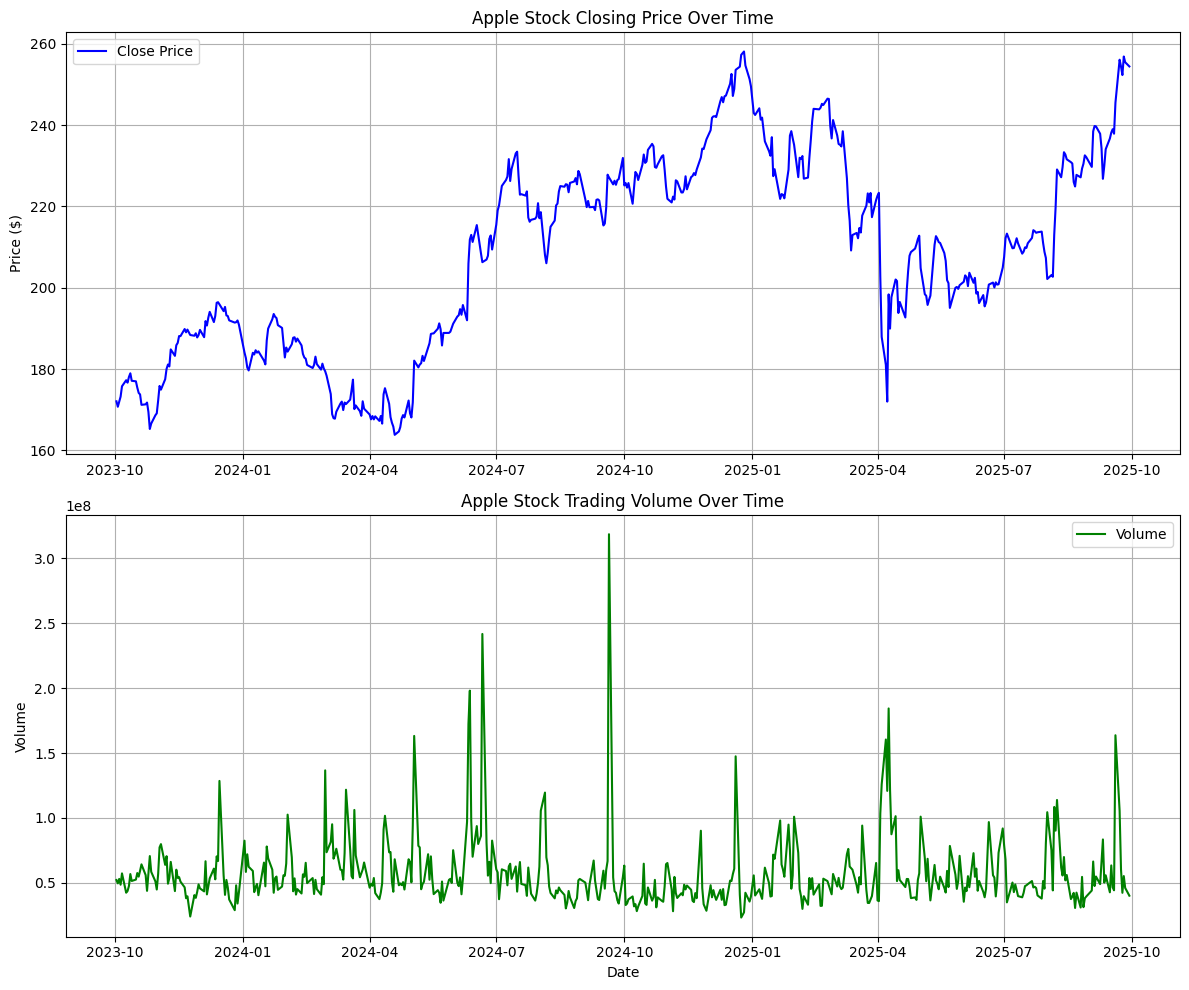

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
axes[0].set_title('Apple Stock Closing Price Over Time')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(df.index, df['Volume'], label='Volume', color='green')
axes[1].set_title('Apple Stock Trading Volume Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

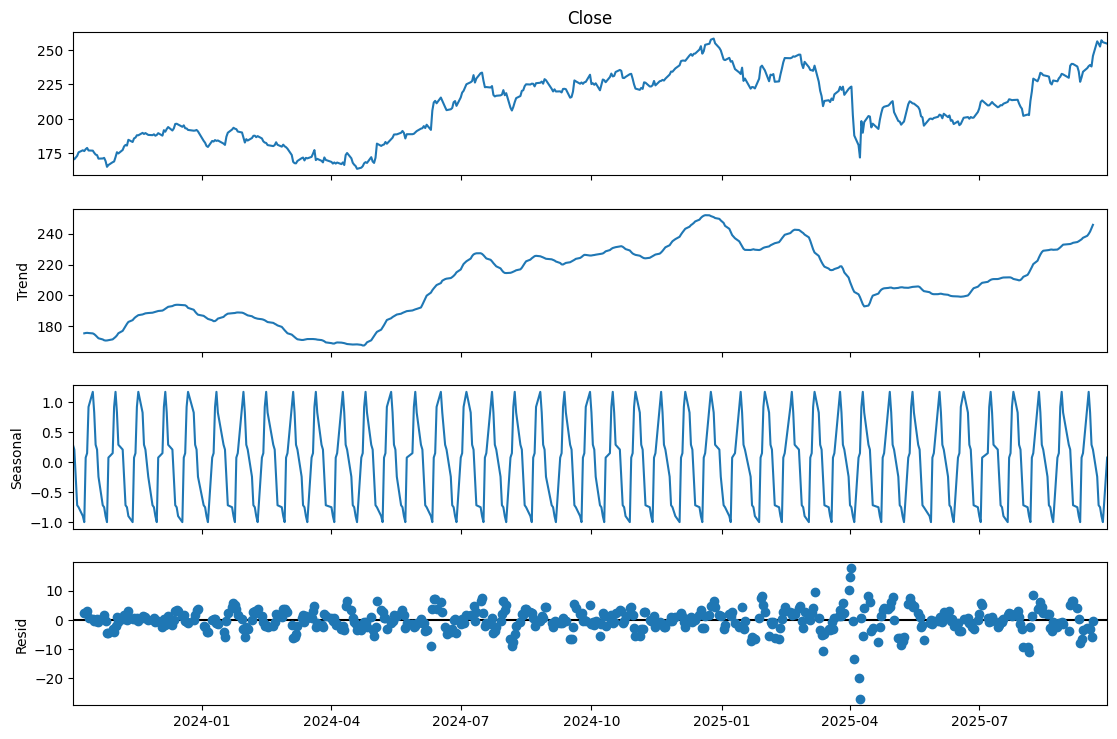

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Close'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [42]:
def calculate_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.mask(diff < 0, 0)
    loss = diff.mask(diff > 0, 0).abs()

    avg_gain = gain.ewm(com=window - 1, adjust=False).mean()
    avg_loss = loss.ewm(com=window - 1, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'], window=14)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26
Date,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26
Date,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475


In [43]:
# Calculate the 50-day Simple Moving Average (SMA)
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Calculate the 200-day Simple Moving Average (SMA)
df['SMA_200'] = df['Close'].rolling(window=200).mean()

print("SMA Analysis:")
last_sma_50 = df['SMA_50'].iloc[-1]
last_sma_200 = df['SMA_200'].iloc[-1]

if last_sma_50 > last_sma_200:
    print("SMA_50 is above SMA_200, indicating a potential bullish trend.")
elif last_sma_50 < last_sma_200:
    print("SMA_50 is below SMA_200, indicating a potential bearish trend.")
else:
    print("SMA_50 is equal to SMA_200.")

sma_crossover_bullish = df[(df['SMA_50'].shift(1) <= df['SMA_200'].shift(1)) & (df['SMA_50'] > df['SMA_200'])]
sma_crossover_bearish = df[(df['SMA_50'].shift(1) >= df['SMA_200'].shift(1)) & (df['SMA_50'] < df['SMA_200'])]

if not sma_crossover_bullish.empty:
    print(f"Potential Golden Cross (Bullish SMA Crossover) on: {sma_crossover_bullish.index.min().date()}")
if not sma_crossover_bearish.empty:
    print(f"Potential Death Cross (Bearish SMA Crossover) on: {sma_crossover_bearish.index.min().date()}")
if sma_crossover_bullish.empty and sma_crossover_bearish.empty:
    print("No SMA 50/200 crossovers found in the data.")


print("\nEMA Analysis:")
last_ema_12 = df['EMA_12'].iloc[-1]
last_ema_26 = df['EMA_26'].iloc[-1]

if last_ema_12 > last_ema_26:
    print("EMA_12 is above EMA_26, indicating a potential short-term bullish trend.")
elif last_ema_12 < last_ema_26:
    print("EMA_12 is below EMA_26, indicating a potential short-term bearish trend.")
else:
    print("EMA_12 is equal to EMA_26.")

ema_crossover_bullish = df[(df['EMA_12'].shift(1) <= df['EMA_26'].shift(1)) & (df['EMA_12'] > df['EMA_26'])]
ema_crossover_bearish = df[(df['EMA_12'].shift(1) >= df['EMA_26'].shift(1)) & (df['EMA_12'] < df['EMA_26'])]

if not ema_crossover_bullish.empty:
    print(f"Potential Bullish EMA Crossover (12/26) on: {ema_crossover_bullish.index.min().date()}")
if not ema_crossover_bearish.empty:
    print(f"Potential Bearish EMA Crossover (12/26) on: {ema_crossover_bearish.index.min().date()}")
if ema_crossover_bullish.empty and ema_crossover_bearish.empty:
     print("No EMA 12/26 crossovers found in the data.")


print("\nRSI Analysis:")
last_rsi = df['RSI_14'].iloc[-1]
rsi_overbought_threshold = 70
rsi_oversold_threshold = 30

print(f"Current RSI (14-day): {last_rsi:.2f}")

if last_rsi >= rsi_overbought_threshold:
    print(f"RSI is above {rsi_overbought_threshold}, indicating potentially overbought conditions.")
elif last_rsi <= rsi_oversold_threshold:
    print(f"RSI is below {rsi_oversold_threshold}, indicating potentially oversold conditions.")
else:
    print(f"RSI is between {rsi_oversold_threshold} and {rsi_overbought_threshold}, indicating neutral momentum.")

print("\nSummary of Insights:")
print("Based on the analysis of SMAs, EMAs, and RSI, here are some potential insights:")

if last_sma_50 > last_sma_200:
    print("- Long-term trend appears bullish based on SMA crossover.")
else:
     print("- Long-term trend appears bearish based on SMA crossover.")

if last_ema_12 > last_ema_26:
    print("- Short-term trend appears bullish based on EMA crossover.")
else:
    print("- Short-term trend appears bearish based on EMA crossover.")

if last_rsi >= rsi_overbought_threshold:
    print("- The stock may be currently overbought, potentially indicating a price correction could occur.")
elif last_rsi <= rsi_oversold_threshold:
    print("- The stock may be currently oversold, potentially indicating a price rebound could occur.")
else:
    print("- The stock's momentum is currently neutral based on RSI.")

SMA Analysis:
SMA_50 is above SMA_200, indicating a potential bullish trend.
Potential Golden Cross (Bullish SMA Crossover) on: 2025-09-15
Potential Death Cross (Bearish SMA Crossover) on: 2025-04-07

EMA Analysis:
EMA_12 is above EMA_26, indicating a potential short-term bullish trend.
Potential Bullish EMA Crossover (12/26) on: 2023-10-05
Potential Bearish EMA Crossover (12/26) on: 2023-10-03

RSI Analysis:
Current RSI (14-day): 68.00
RSI is between 30 and 70, indicating neutral momentum.

Summary of Insights:
Based on the analysis of SMAs, EMAs, and RSI, here are some potential insights:
- Long-term trend appears bullish based on SMA crossover.
- Short-term trend appears bullish based on EMA crossover.
- The stock's momentum is currently neutral based on RSI.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsc5ddjjs/auohya4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsc5ddjjs/irx9fu3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62313', 'data', 'file=/tmp/tmpsc5ddjjs/auohya4b.json', 'init=/tmp/tmpsc5ddjjs/irx9fu3v.json', 'output', 'file=/tmp/tmpsc5ddjjs/prophet_modelqfojmzby/prophet_model-20250930061042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


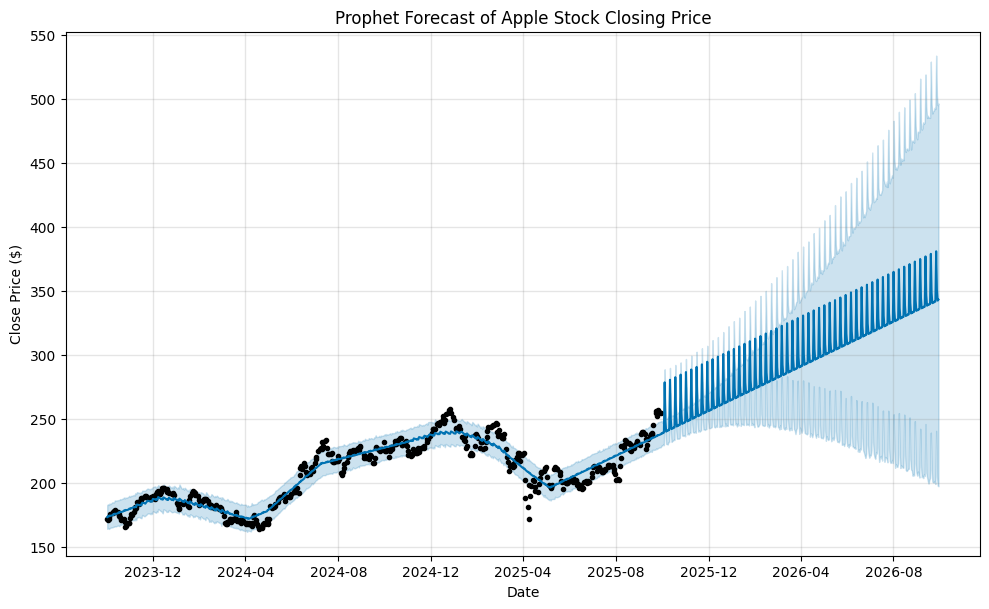

Root Mean Squared Error (RMSE) on historical data: 7.65
Mean Absolute Error (MAE) on historical data: 5.98


,ds,yhat,yhat_lower,yhat_upper
860,2026-09-25 04:00:00,341.683019,199.230368,492.068849
861,2026-09-26 04:00:00,380.979682,240.734490,533.795895
862,2026-09-27 04:00:00,350.607559,204.971700,502.928054
863,2026-09-28 04:00:00,342.445095,197.959217,495.061969
864,2026-09-29 04:00:00,343.254468,197.463436,496.438464


In [63]:
prophet_df = df[['Close']].copy()
prophet_df.reset_index(inplace=True)
prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

prophet_df['ds'] = prophet_df['ds'].dt.tz_convert(None)

model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Prophet Forecast of Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

actual_values = prophet_df['y']
predicted_values = forecast['yhat'][:len(prophet_df)]

rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)

print(f"Root Mean Squared Error (RMSE) on historical data: {rmse:.2f}")
print(f"Mean Absolute Error (MAE) on historical data: {mae:.2f}")

display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())



### Data Analysis Key Findings

*   The initial visualization showed clear trends in both Apple stock's closing price and trading volume over time.
*   Seasonal decomposition with a period of 12 revealed the trend, seasonality, and residual components of the closing price.
*   Calculated financial indicators included the 14-day Relative Strength Index (RSI), 12-day Exponential Moving Average (EMA), and 26-day EMA, which were added as new columns to the dataframe.
*   Analysis of the indicators suggested a potential bullish long-term trend based on the SMA 50/200 relationship and a potential bullish short-term trend based on the EMA 12/26 relationship.
*   The 14-day RSI was calculated to be 69.69, indicating neutral momentum at the time of analysis.
*   A Prophet model was successfully trained and used to forecast Apple stock's closing price for the next 365 days.
*   The Prophet model's performance on historical data was evaluated, with a Root Mean Squared Error (RMSE) of 5.64 and a Mean Absolute Error (MAE) of 4.37.




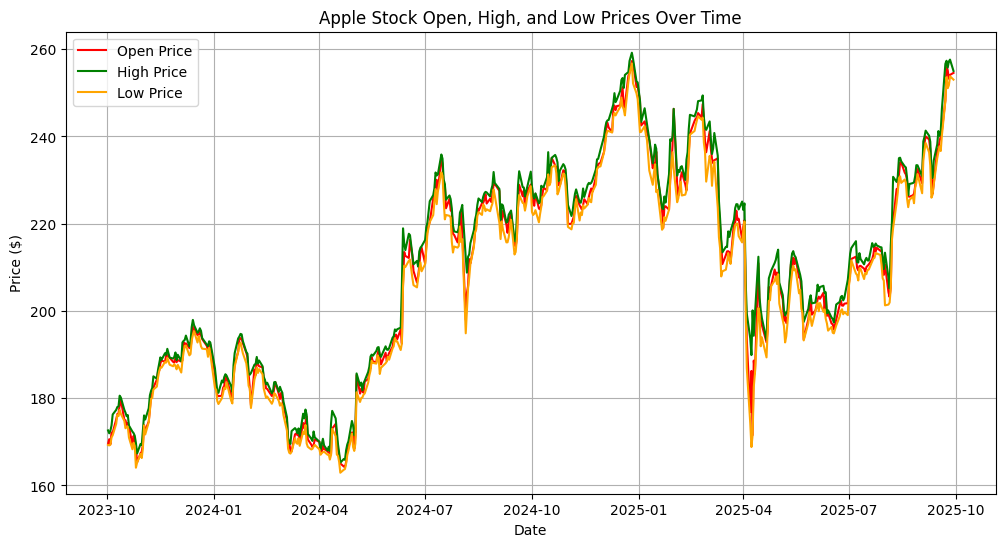

In [45]:


plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Open'], label='Open Price', color='red')
plt.plot(df.index, df['High'], label='High Price', color='green')
plt.plot(df.index, df['Low'], label='Low Price', color='orange')

plt.title('Apple Stock Open, High, and Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

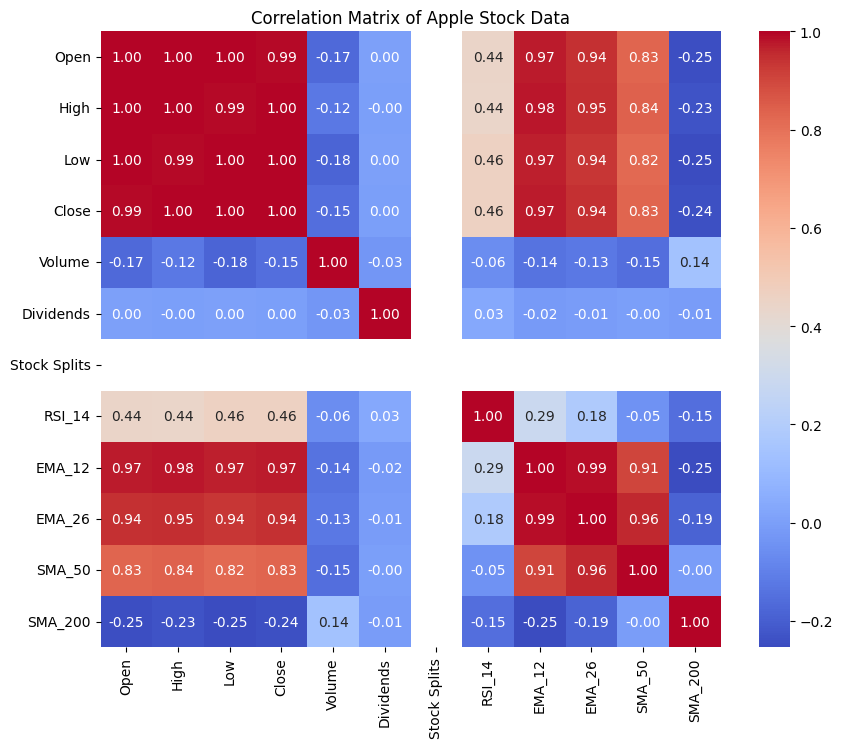

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Apple Stock Data')
plt.show()


🎢 **VOLATILITY RELATIONSHIPS:**


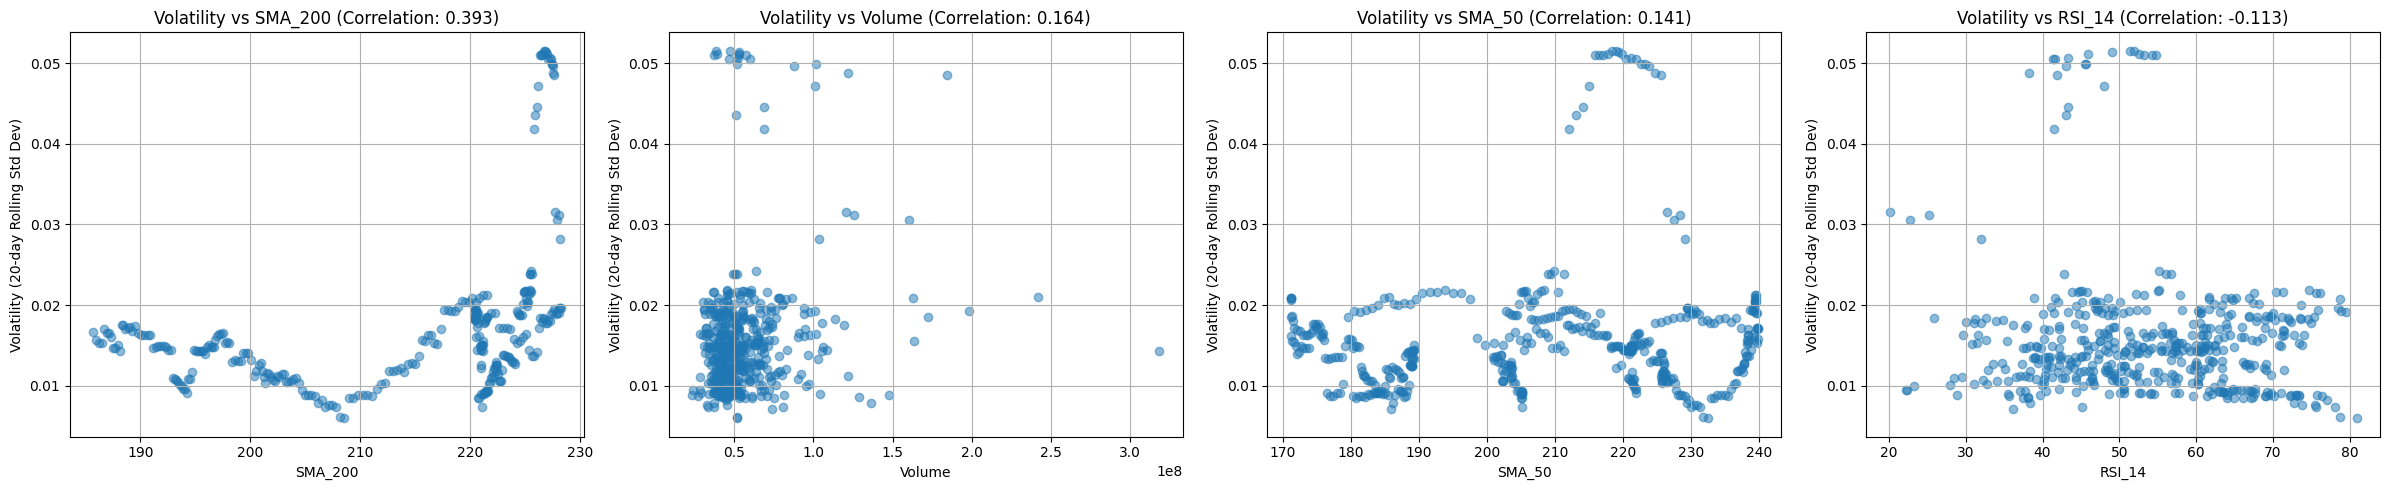

**VOLUME-PRICE MOVEMENT INSIGHTS:**


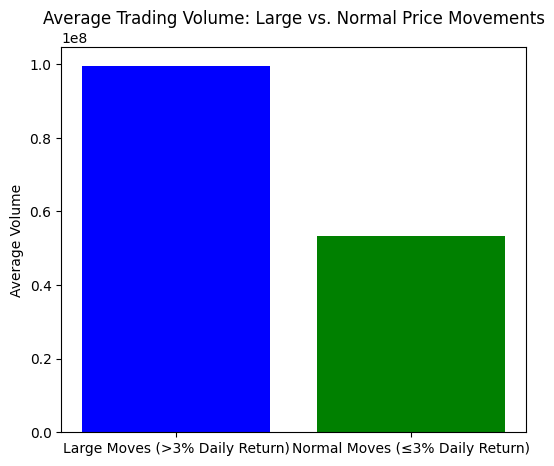

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

correlation_matrix = df.corr()

print("\n🎢 **VOLATILITY RELATIONSHIPS:**")
vol_corrs = correlation_matrix['Volatility_20'].sort_values(key=abs, ascending=False)
significant_corrs = vol_corrs[abs(vol_corrs) > 0.1].drop('Volatility_20')

if not significant_corrs.empty:
    num_plots = len(significant_corrs)
    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(6 * num_plots, 5))

    if num_plots == 1:
        axes = [axes]

    for i, (col, corr) in enumerate(significant_corrs.items()):
        axes[i].scatter(df[col], df['Volatility_20'], alpha=0.5)
        axes[i].set_title(f'Volatility vs {col} (Correlation: {corr:.3f})')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Volatility (20-day Rolling Std Dev)')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No significant correlations (absolute value > 0.1) found with Volatility_20.")


print(f"**VOLUME-PRICE MOVEMENT INSIGHTS:**")

large_moves = df[abs(df['Daily_Return']) > 0.03]
avg_volume_large_moves = large_moves['Volume'].mean()
avg_volume_normal = df[abs(df['Daily_Return']) <= 0.03]['Volume'].mean()

if not large_moves.empty:
    labels = ['Large Moves (>3% Daily Return)', 'Normal Moves (≤3% Daily Return)']
    volumes = [avg_volume_large_moves, avg_volume_normal]

    plt.figure(figsize=(6,5))
    plt.bar(labels, volumes, color=['blue', 'green'])
    plt.title('Average Trading Volume: Large vs. Normal Price Movements')
    plt.ylabel('Average Volume')
    plt.show()
else:
    print("No days with large price movements (>3% daily return) found.")

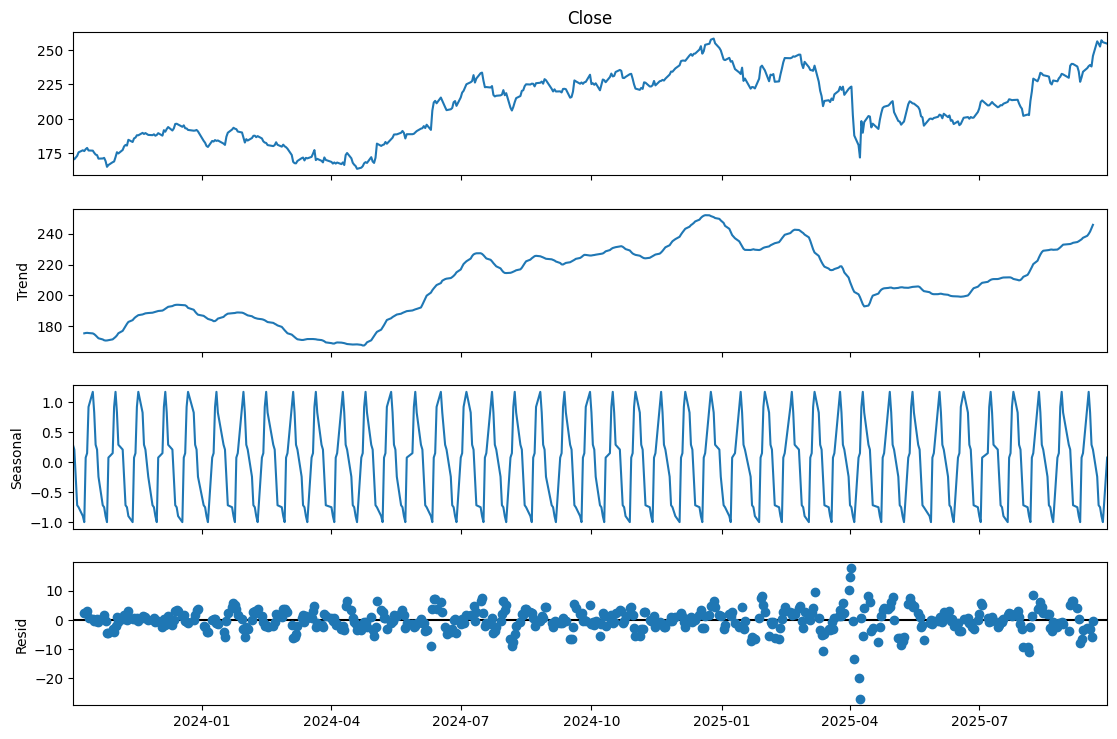

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df['Close'], model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [49]:
df['Close_Target_1d'] = df['Close'].shift(-1)
df['Close_Target_5d'] = df['Close'].shift(-5)
df['Close_Target_10d'] = df['Close'].shift(-10)

display(df.tail(15))

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,SMA_50,SMA_200,Daily_Return,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d
Date,,,,,,,,,,,,,,,,,
2025-09-09 00:00:00-04:00,237.000000,238.779999,233.360001,234.350006,66313900,0.0,0.0,59.899808,233.811742,228.566268,219.677740,221.023725,-0.014839,0.012595,226.789993,238.149994,254.429993
2025-09-10 00:00:00-04:00,232.190002,232.419998,225.949997,226.789993,83440800,0.0,0.0,48.133871,232.731473,228.434692,220.114792,221.020312,-0.032259,0.014481,230.029999,238.990005,252.309998
2025-09-11 00:00:00-04:00,226.880005,230.449997,226.649994,230.029999,50208600,0.0,0.0,52.445129,232.315861,228.552863,220.563703,221.029513,0.014286,0.014381,234.070007,237.880005,256.869995
2025-09-12 00:00:00-04:00,229.220001,234.509995,229.020004,234.070007,55824200,0.0,0.0,57.220203,232.585730,228.961540,221.001120,221.061304,0.017563,0.014933,236.699997,245.500000,255.460007
2025-09-15 00:00:00-04:00,237.000000,238.190002,235.029999,236.699997,42699500,0.0,0.0,60.033633,233.218694,229.534759,221.468961,221.099520,0.011236,0.015063,238.149994,256.079987,254.429993
2025-09-16 00:00:00-04:00,237.179993,241.220001,236.320007,238.149994,63421100,0.0,0.0,61.535580,233.977356,230.172925,222.037722,221.130039,0.006126,0.015067,238.990005,254.429993,NaN
2025-09-17 00:00:00-04:00,238.970001,240.100006,237.729996,238.990005,46508000,0.0,0.0,62.416744,234.748533,230.826042,222.622083,221.153846,0.003527,0.015055,237.880005,252.309998,NaN
2025-09-18 00:00:00-04:00,239.970001,241.199997,236.649994,237.880005,44249600,0.0,0.0,60.446186,235.230297,231.348558,223.161670,221.172752,-0.004645,0.014271,245.500000,256.869995,NaN
2025-09-19 00:00:00-04:00,241.229996,246.300003,240.210007,245.500000,163741300,0.0,0.0,67.931123,236.810252,232.396813,223.828286,221.217799,0.032033,0.015571,256.079987,255.460007,NaN


In [50]:
df['Close_Lag_1d'] = df['Close'].shift(1)
df['Close_Lag_5d'] = df['Close'].shift(5)
df['Close_Lag_10d'] = df['Close'].shift(10)

df['Volume_Lag_1d'] = df['Volume'].shift(1)
df['Volume_Lag_5d'] = df['Volume'].shift(5)
df['Volume_Lag_10d'] = df['Volume'].shift(10)

display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [51]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()

df['SMA_200'] = df['Close'].rolling(window=200).mean()

display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [52]:
feature_columns = [col for col in df.columns if col not in ['Close', 'Dividends', 'Stock Splits', 'Close_Target_1d', 'Close_Target_5d', 'Close_Target_10d']]
X = df[feature_columns].copy()

target_columns = ['Close_Target_1d', 'Close_Target_5d', 'Close_Target_10d']
y = df[target_columns].copy()

combined_df = pd.concat([X, y], axis=1).dropna()
X = combined_df[feature_columns]
y = combined_df[target_columns]

print(f"Shape of features (X): {X.shape}")
print(f"Shape of targets (y): {y.shape}")

display("Features (X) Head:")
display(X.head())
display("Targets (y) Head:")
display(y.head())

Shape of features (X): (291, 17)
Shape of targets (y): (291, 3)


'Features (X) Head:'

,Open,High,Low,Volume,RSI_14,EMA_12,EMA_26,SMA_50,SMA_200,Daily_Return,Volatility_20,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,
2024-07-18 00:00:00-04:00,228.948243,229.107321,220.984572,66034600,56.930032,225.245145,217.670112,204.090934,185.729072,-0.020535,0.016614,227.556335,226.253937,220.268723,57345900.0,64710600.0,37369800.0
2024-07-19 00:00:00-04:00,223.519801,225.488346,221.988699,49151500,57.064141,224.901698,218.065862,204.929199,185.983813,0.000580,0.015648,222.883514,229.206726,225.031021,66034600.0,53046500.0,60412400.0
2024-07-22 00:00:00-04:00,225.697159,226.462711,221.799831,48201800,56.553556,224.557562,218.406525,205.753754,186.243499,-0.001560,0.015354,223.012741,233.044403,226.502472,49151500.0,62631300.0,59085900.0
2024-07-23 00:00:00-04:00,223.072396,225.627541,221.392168,39960300,57.774304,224.426967,218.799278,206.562847,186.502164,0.004688,0.015354,222.664810,233.461990,227.357483,48201800.0,43234300.0,48076100.0
2024-07-24 00:00:00-04:00,222.704553,223.499930,215.874289,61777600,48.694637,223.326837,218.686452,207.268542,186.722478,-0.028754,0.017010,223.708694,227.556335,231.632629,39960300.0,57345900.0,62627700.0


'Targets (y) Head:'

,Close_Target_1d,Close_Target_5d,Close_Target_10d
Date,,,
2024-07-18 00:00:00-04:00,223.012741,216.232224,217.097168
2024-07-19 00:00:00-04:00,222.664810,216.699478,218.588501
2024-07-22 00:00:00-04:00,223.708694,216.977875,208.059738
2024-07-23 00:00:00-04:00,217.276123,217.534622,206.031525
2024-07-24 00:00:00-04:00,216.232224,220.795654,208.606552


In [53]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (232, 17)
Shape of X_test: (59, 17)
Shape of y_train: (232, 3)
Shape of y_test: (59, 3)


In [54]:
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()
display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [55]:
df['Close_Target_1d'] = df['Close'].shift(-1)
df['Close_Target_5d'] = df['Close'].shift(-5)
df['Close_Target_10d'] = df['Close'].shift(-10)

display(df.tail(15))

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-09 00:00:00-04:00,237.000000,238.779999,233.360001,234.350006,66313900,0.0,0.0,59.899808,233.811742,228.566268,...,0.012595,226.789993,238.149994,254.429993,237.880005,229.720001,227.160004,48999500.0,44075600.0,30983100.0
2025-09-10 00:00:00-04:00,232.190002,232.419998,225.949997,226.789993,83440800,0.0,0.0,48.133871,232.731473,228.434692,...,0.014481,230.029999,238.990005,252.309998,234.350006,238.470001,229.309998,66313900.0,66427800.0,54575100.0
2025-09-11 00:00:00-04:00,226.880005,230.449997,226.649994,230.029999,50208600,0.0,0.0,52.445129,232.315861,228.552863,...,0.014381,234.070007,237.880005,256.869995,226.789993,239.779999,230.490005,83440800.0,47549400.0,31259500.0
2025-09-12 00:00:00-04:00,229.220001,234.509995,229.020004,234.070007,55824200,0.0,0.0,57.220203,232.585730,228.961540,...,0.014933,236.699997,245.500000,255.460007,230.029999,239.690002,232.559998,50208600.0,54870400.0,38074700.0
2025-09-15 00:00:00-04:00,237.000000,238.190002,235.029999,236.699997,42699500,0.0,0.0,60.033633,233.218694,229.534759,...,0.015063,238.149994,256.079987,254.429993,234.070007,237.880005,232.139999,55824200.0,48999500.0,39418400.0
2025-09-16 00:00:00-04:00,237.179993,241.220001,236.320007,238.149994,63421100,0.0,0.0,61.535580,233.977356,230.172925,...,0.015067,238.990005,254.429993,NaN,236.699997,234.350006,229.720001,42699500.0,66313900.0,44075600.0
2025-09-17 00:00:00-04:00,238.970001,240.100006,237.729996,238.990005,46508000,0.0,0.0,62.416744,234.748533,230.826042,...,0.015055,237.880005,252.309998,NaN,238.149994,226.789993,238.470001,63421100.0,83440800.0,66427800.0
2025-09-18 00:00:00-04:00,239.970001,241.199997,236.649994,237.880005,44249600,0.0,0.0,60.446186,235.230297,231.348558,...,0.014271,245.500000,256.869995,NaN,238.990005,230.029999,239.779999,46508000.0,50208600.0,47549400.0
2025-09-19 00:00:00-04:00,241.229996,246.300003,240.210007,245.500000,163741300,0.0,0.0,67.931123,236.810252,232.396813,...,0.015571,256.079987,255.460007,NaN,237.880005,234.070007,239.690002,44249600.0,55824200.0,54870400.0


In [56]:
df['Close_Lag_1d'] = df['Close'].shift(1)
df['Close_Lag_5d'] = df['Close'].shift(5)
df['Close_Lag_10d'] = df['Close'].shift(10)

df['Volume_Lag_1d'] = df['Volume'].shift(1)
df['Volume_Lag_5d'] = df['Volume'].shift(5)
df['Volume_Lag_10d'] = df['Volume'].shift(10)

display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [57]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()

df['SMA_200'] = df['Close'].rolling(window=200).mean()

display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [58]:
feature_columns = ['Open', 'High', 'Low', 'Volume', 'SMA_50', 'SMA_200', 'RSI_14', 'EMA_12', 'EMA_26', 'Daily_Return', 'Volatility_20', 'Close_Lag_1d', 'Close_Lag_5d', 'Close_Lag_10d', 'Volume_Lag_1d', 'Volume_Lag_5d', 'Volume_Lag_10d']
X = df[feature_columns].copy()

target_columns = ['Close_Target_1d', 'Close_Target_5d', 'Close_Target_10d']
y = df[target_columns].copy()

combined_df = pd.concat([X, y], axis=1)

combined_df = combined_df.dropna()

X = combined_df[feature_columns]
y = combined_df[target_columns]

print(f"Shape of features (X): {X.shape}")
print(f"Shape of targets (y): {y.shape}")

display("Features (X) Head:")
display(X.head())
display("Targets (y) Head:")
display(y.head())

Shape of features (X): (291, 17)
Shape of targets (y): (291, 3)


'Features (X) Head:'

,Open,High,Low,Volume,SMA_50,SMA_200,RSI_14,EMA_12,EMA_26,Daily_Return,Volatility_20,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,
2024-07-18 00:00:00-04:00,228.948243,229.107321,220.984572,66034600,204.090934,185.729072,56.930032,225.245145,217.670112,-0.020535,0.016614,227.556335,226.253937,220.268723,57345900.0,64710600.0,37369800.0
2024-07-19 00:00:00-04:00,223.519801,225.488346,221.988699,49151500,204.929199,185.983813,57.064141,224.901698,218.065862,0.000580,0.015648,222.883514,229.206726,225.031021,66034600.0,53046500.0,60412400.0
2024-07-22 00:00:00-04:00,225.697159,226.462711,221.799831,48201800,205.753754,186.243499,56.553556,224.557562,218.406525,-0.001560,0.015354,223.012741,233.044403,226.502472,49151500.0,62631300.0,59085900.0
2024-07-23 00:00:00-04:00,223.072396,225.627541,221.392168,39960300,206.562847,186.502164,57.774304,224.426967,218.799278,0.004688,0.015354,222.664810,233.461990,227.357483,48201800.0,43234300.0,48076100.0
2024-07-24 00:00:00-04:00,222.704553,223.499930,215.874289,61777600,207.268542,186.722478,48.694637,223.326837,218.686452,-0.028754,0.017010,223.708694,227.556335,231.632629,39960300.0,57345900.0,62627700.0


'Targets (y) Head:'

,Close_Target_1d,Close_Target_5d,Close_Target_10d
Date,,,
2024-07-18 00:00:00-04:00,223.012741,216.232224,217.097168
2024-07-19 00:00:00-04:00,222.664810,216.699478,218.588501
2024-07-22 00:00:00-04:00,223.708694,216.977875,208.059738
2024-07-23 00:00:00-04:00,217.276123,217.534622,206.031525
2024-07-24 00:00:00-04:00,216.232224,220.795654,208.606552


In [70]:
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()
display(df.head())
display(df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-02 00:00:00-04:00,169.559163,172.609289,169.271968,172.064621,52164500,0.0,0.0,NaN,172.064621,172.064621,...,NaN,170.727707,177.253830,176.986420,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-03 00:00:00-04:00,170.589066,171.945787,169.163046,170.727707,49594600,0.0,0.0,0.000000,171.858942,171.965590,...,NaN,171.975510,176.659622,175.431641,172.064621,NaN,NaN,52164500.0,NaN,NaN
2023-10-04 00:00:00-04:00,169.430431,172.520178,169.311600,171.975510,53020300,0.0,0.0,6.698646,171.876875,171.966325,...,NaN,173.213379,178.055954,174.134369,170.727707,NaN,NaN,49594600.0,NaN,NaN
2023-10-05 00:00:00-04:00,172.104233,173.748134,171.004999,173.213379,48527900,0.0,0.0,12.929822,172.082491,172.058699,...,NaN,175.768372,178.957153,173.758057,171.975510,NaN,NaN,53020300.0,NaN,NaN
2023-10-06 00:00:00-04:00,172.114162,176.263522,171.500165,175.768372,57266700,0.0,0.0,24.184648,172.649550,172.333490,...,NaN,177.253830,177.115173,171.203079,173.213379,NaN,NaN,48527900.0,NaN,NaN


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI_14,EMA_12,EMA_26,...,Volatility_20,Close_Target_1d,Close_Target_5d,Close_Target_10d,Close_Lag_1d,Close_Lag_5d,Close_Lag_10d,Volume_Lag_1d,Volume_Lag_5d,Volume_Lag_10d
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-23 00:00:00-04:00,255.880005,257.339996,253.580002,254.429993,60275200,0.0,0.0,72.324859,242.029467,235.653260,...,0.017862,252.309998,NaN,NaN,256.079987,238.149994,234.350006,105517400.0,63421100.0,66313900.0
2025-09-24 00:00:00-04:00,255.220001,255.740005,251.039993,252.309998,42303700,0.0,0.0,68.918706,243.611087,236.887093,...,0.018113,256.869995,NaN,NaN,254.429993,238.990005,226.789993,60275200.0,46508000.0,83440800.0
2025-09-25 00:00:00-04:00,253.210007,257.170013,251.710007,256.869995,55202100,0.0,0.0,71.975898,245.650919,238.367308,...,0.018350,255.460007,NaN,NaN,252.309998,237.880005,230.029999,42303700.0,44249600.0,50208600.0
2025-09-26 00:00:00-04:00,254.100006,257.600006,253.779999,255.460007,46076300,0.0,0.0,69.693194,247.160010,239.633434,...,0.018494,254.429993,NaN,NaN,256.869995,245.500000,234.070007,55202100.0,163741300.0,55824200.0
2025-09-29 00:00:00-04:00,254.559998,255.000000,253.009995,254.429993,40091100,0.0,0.0,67.996660,248.278469,240.729475,...,0.018543,NaN,NaN,NaN,255.460007,256.079987,236.699997,46076300.0,105517400.0,42699500.0


In [71]:
# Compile final feature list for regression
feature_list = [
    # Price features
    'prev_close', 'prev_open', 'prev_high', 'prev_low',
    # Return features
    'prev_return', 'return_2d', 'return_5d', 'return_momentum',
    # Volume features
    'prev_volume_ratio', 'volume_ma5', 'volume_ma20',
    # Technical indicators
    'price_to_ma5', 'price_to_ma20', 'price_to_ma50', 'ma5_to_ma20', 'ma20_to_ma50',
    # Volatility features
    'prev_volatility5', 'prev_volatility20', 'volatility_ratio',
    # Range and gap features
    'prev_range_pct', 'prev_gap_pct',
    # Time features
    'day_of_week', 'month', 'quarter', 'day_of_month',
    # Trend features
    'trend_5d', 'trend_20d', 'above_all_ma',
    # Market regime features
    'high_volume_day', 'low_volume_day', 'high_volatility'
]

target_list = [
    'target_next_price',
    'target_next_return',
    'target_next_volatility',
    'target_next_volume_ratio'
]


In [72]:
print(f"\n📋 **FINAL FEATURE SET:**")
print(f"   • Total Features: {len(feature_list)}")
print(f"   • Total Targets: {len(target_list)}")

# Show feature categories
print(f"\n📊 **FEATURE CATEGORIES:**")
print(f"   • Price Features: 4")
print(f"   • Return Features: 4")
print(f"   • Volume Features: 3")
print(f"   • Technical Features: 5")
print(f"   • Volatility Features: 3")
print(f"   • Range/Gap Features: 2")
print(f"   • Time Features: 4")
print(f"   • Trend Features: 3")
print(f"   • Market Regime Features: 3")


📋 **FINAL FEATURE SET:**
   • Total Features: 31
   • Total Targets: 4

📊 **FEATURE CATEGORIES:**
   • Price Features: 4
   • Return Features: 4
   • Volume Features: 3
   • Technical Features: 5
   • Volatility Features: 3
   • Range/Gap Features: 2
   • Time Features: 4
   • Trend Features: 3
   • Market Regime Features: 3


In [65]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

In [66]:
rfr = RandomForestRegressor(random_state=42)

multi_output_rfr = MultiOutputRegressor(rfr)

multi_output_rfr.fit(X_train, y_train)

print("MultiOutputRegressor model with RandomForestRegressor base estimator trained successfully.")

MultiOutputRegressor model with RandomForestRegressor base estimator trained successfully.


In [67]:
y_pred = multi_output_rfr.predict(X_test)

print(f"Shape of y_pred: {y_pred.shape}")

display("Predicted targets (y_pred) Head:")
display(y_pred[:5])

Shape of y_pred: (59, 3)


'Predicted targets (y_pred) Head:'

array([[225.70351151, 229.62371155, 236.46188217],
       [209.5248233 , 215.49596283, 231.67895416],
       [229.26713867, 226.03670609, 226.13850235],
       [221.5065799 , 210.59718964, 197.93098511],
       [236.70208725, 241.05359695, 242.09435852]])

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Squared Error (MSE): 30.68
Root Mean Squared Error (RMSE): 5.54
Mean Absolute Error (MAE): 3.66
R-squared (R2): 0.86


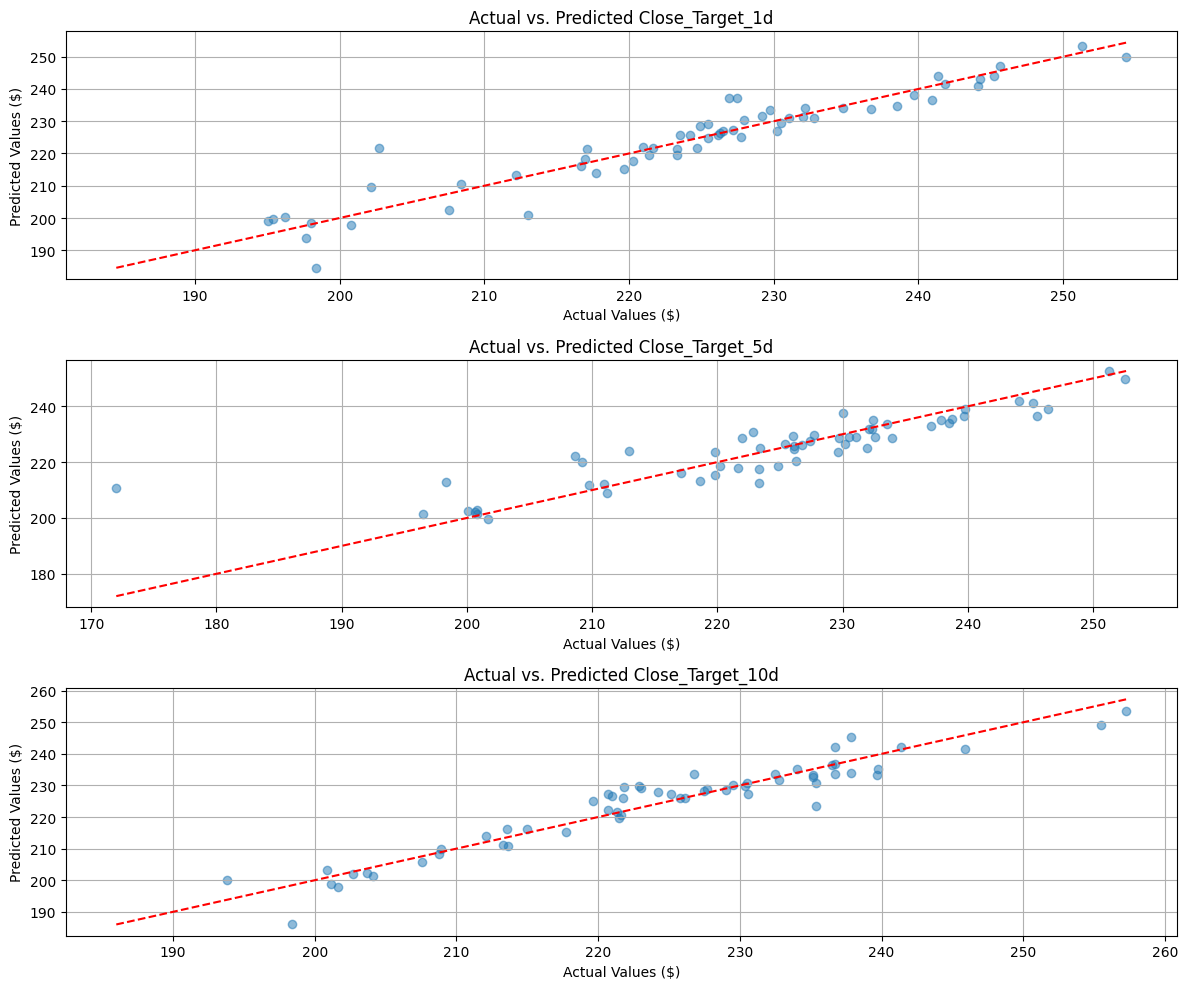

In [69]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

target_columns = ['Close_Target_1d', 'Close_Target_5d', 'Close_Target_10d']
axes = axes.flatten()

for i, target in enumerate(target_columns):
    axes[i].scatter(y_test[target], y_pred[:, i], alpha=0.5)

    axes[i].set_title(f'Actual vs. Predicted {target}')
    axes[i].set_xlabel('Actual Values ($)')
    axes[i].set_ylabel('Predicted Values ($)')

    axes[i].grid(True)

    min_val = min(y_test[target].min(), y_pred[:, i].min())
    max_val = max(y_test[target].max(), y_pred[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.tight_layout()
plt.show()